In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# ML models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
# Multilayer Perceptron
from keras import Model
from keras.api.layers import Input
from keras.api.layers import Dense
from keras.api.layers import Dropout
from keras.api.layers import concatenate
from keras import optimizers
from keras import backend
from keras.api.layers import LeakyReLU, PReLU


2025-01-07 11:12:58.334765: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-07 11:12:58.412527: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-07 11:12:58.459900: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-07 11:12:58.470571: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-07 11:12:58.527198: I tensorflow/core/platform/cpu_feature_guar

In [3]:
#!git clone https://github.com/simsekergun/photodetectors.git
df = pd.read_csv("./MUTC1750designs.csv")

In [4]:
# let's take log10 of doping levels so that we deal with numbers in the similar ranges
df[df.columns[22:40]] =np.log10(df[df.columns[22:40]])
df.shape

(1755, 39)

In [5]:
df.head(3)

,phasenoise,phasenoise_15mA,current,IR_max,decay_time,t1,t2,t3,t4,t5,...,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17
0,-161.516,-170.938,0.001713,32002500000,184.775,20.7,121.5,6.0,33.5,96.7,...,18.809560,15.110590,14.963316,15.107210,16.143015,15.408240,18.748188,18.170262,18.928396,18.424882
1,-162.136,-171.316,0.001812,28499800000,161.603,76.7,79.0,85.4,12.0,77.6,...,18.598791,15.753583,16.503791,15.918030,17.227887,14.868644,17.181844,18.193125,18.721811,18.832509
2,-162.661,-172.271,0.001641,34642300000,174.001,86.5,94.5,7.0,16.6,111.4,...,18.836957,16.173186,15.372912,15.287802,16.491362,15.809560,18.100371,17.856124,19.404834,18.217484


In [6]:
df.describe()

,phasenoise,phasenoise_15mA,current,IR_max,decay_time,t1,t2,t3,t4,t5,...,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17
count,1755.000000,1755.000000,1755.000000,1.755000e+03,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,...,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000,1755.000000
mean,-170.904159,-177.668607,0.003658,5.396398e+10,62.732325,47.636524,106.206610,34.891556,43.307134,107.375670,...,17.712256,15.987027,16.378908,16.358700,17.047689,16.258266,17.985147,19.221367,19.013471,19.121494
std,3.845182,2.248727,0.002374,1.190861e+10,31.641076,24.608927,30.429793,23.385138,23.912232,29.172582,...,0.410801,0.442477,0.810166,0.812304,0.441059,0.833403,0.415166,0.545513,0.416695,0.555979
min,-178.621000,-183.613000,0.001459,2.849980e+10,22.224300,10.000000,36.000000,5.000000,6.000000,23.800000,...,16.505150,14.801404,14.801404,14.800029,15.947434,14.801404,16.808886,17.806858,17.800029,17.801404
25%,-173.773000,-179.189500,0.002360,4.545390e+10,37.899700,31.850000,90.300000,15.000000,15.000000,95.900000,...,17.482158,15.761552,15.868937,15.837904,16.781037,15.708421,17.797268,18.905256,18.872714,18.790637
50%,-170.027000,-177.815000,0.002539,5.236430e+10,53.955800,50.000000,100.000000,26.800000,47.000000,100.000000,...,17.698970,16.000000,16.110590,16.064458,17.093422,16.000000,18.000000,19.155336,19.000000,19.000000
75%,-168.358000,-176.220500,0.003013,6.194950e+10,75.028400,52.600000,120.350000,47.200000,60.400000,120.300000,...,17.884795,16.254063,16.993636,16.980648,17.455600,16.897624,18.118923,19.850603,19.167317,19.589391
max,-161.516000,-170.334000,0.009902,9.755770e+10,184.775000,178.000000,199.900000,100.000000,99.900000,199.800000,...,18.987666,17.193125,17.710963,17.687529,17.848805,17.923244,19.873902,20.193125,20.193125,20.195900


In [7]:
## Coefficient of Correlation
df[df.columns[0:5]].std()/df[df.columns[0:5]].mean()

phasenoise        -0.022499
phasenoise_15mA   -0.012657
current            0.649052
IR_max             0.220677
decay_time         0.504382
dtype: float64

In [14]:
# Let us some functions to normalize, de-normalize, and to calculate errors
def normx(x, train_statsX):
  return (x - train_statsX['mean']) / train_statsX['std']
def norm(y, train_statsY):
  return (y - train_statsY['mean']) / train_statsY['std']
def denorm(y, train_statsY):
  return (y* train_statsY['std'] + train_statsY['mean'])  
def mean_aep(u1,u2):  
  return (round(100*(100*sum(abs((u2-u1)/u1))/len(u1)))/100)
def max_aep(u1,u2):  
  return (round(100*(100*max(abs((u2-u1)/u1))))/100)  

In [15]:
# ANN parameters
ac = 'relu'  # activation function
nnno = 48    # number of neurons
dr_rate = 0.2  # dropout rate
EPOCHS = 400    # number of epocs
LR = 0.001     # learning rate

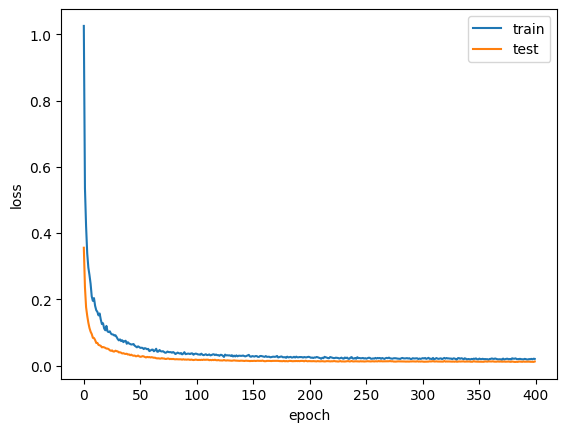

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
************ 0 ************
Mean Absolute Percentage Errors: LR, kNN, RF, ANN
0.38 0.39 0.19 0.18
Max Absolute Percentage Errors: LR, kNN, RF, ANN
1.68 3.32 1.3 1.01


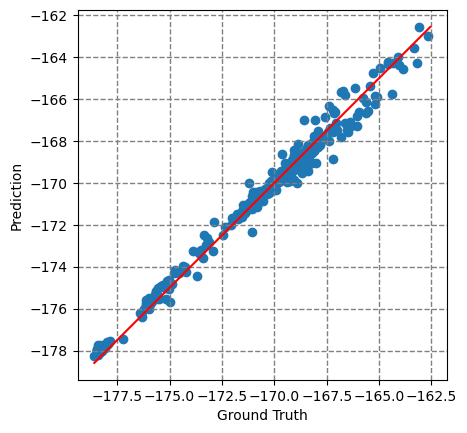

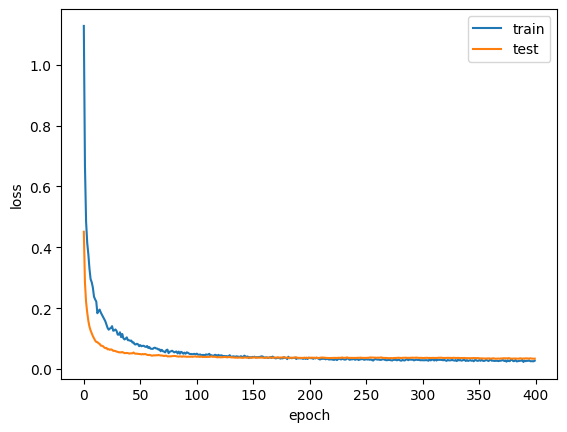

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
************ 1 ************
Mean Absolute Percentage Errors: LR, kNN, RF, ANN
0.26 0.32 0.19 0.15
Max Absolute Percentage Errors: LR, kNN, RF, ANN
1.37 2.25 1.47 1.0


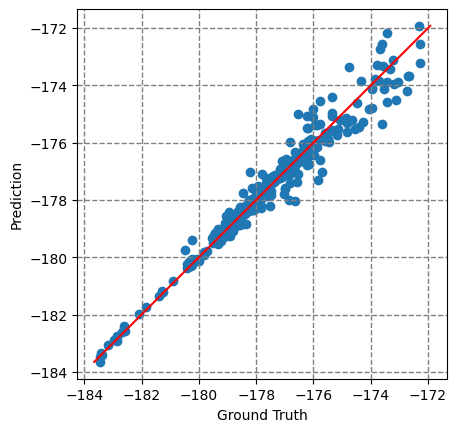

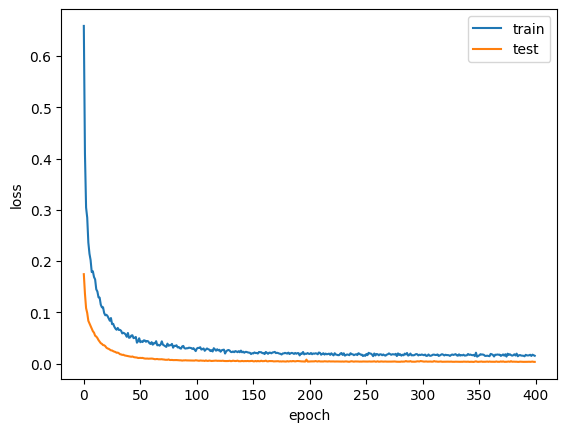

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
************ 2 ************
Mean Absolute Percentage Errors: LR, kNN, RF, ANN
16.81 5.16 3.5 2.71
Max Absolute Percentage Errors: LR, kNN, RF, ANN
110.66 57.08 36.18 21.57


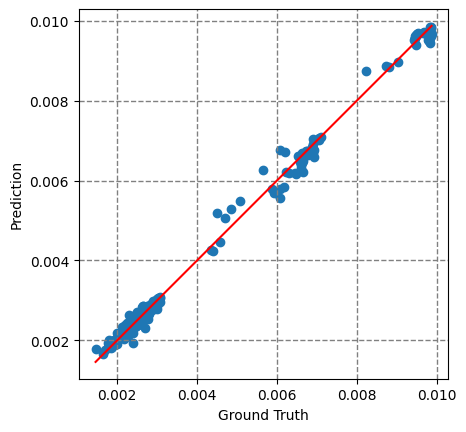

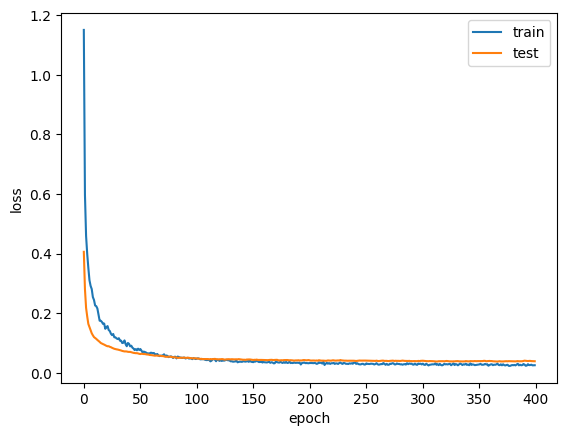

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
************ 3 ************
Mean Absolute Percentage Errors: LR, kNN, RF, ANN
4.81 5.48 3.14 2.88
Max Absolute Percentage Errors: LR, kNN, RF, ANN
30.07 47.61 30.65 25.43


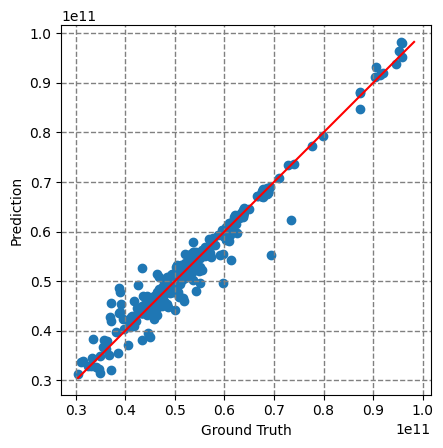

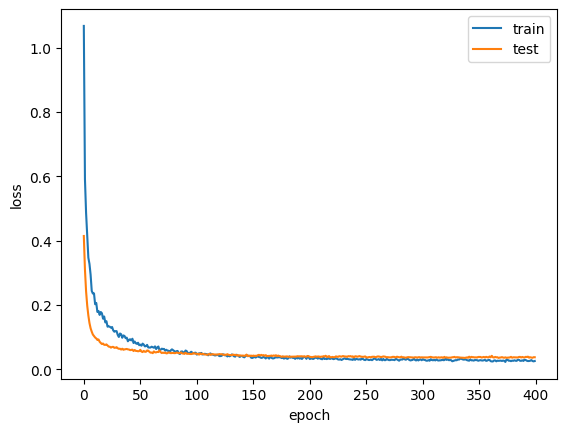

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
************ 4 ************
Mean Absolute Percentage Errors: LR, kNN, RF, ANN
9.91 11.34 7.03 5.3
Max Absolute Percentage Errors: LR, kNN, RF, ANN
99.57 61.48 52.24 58.61


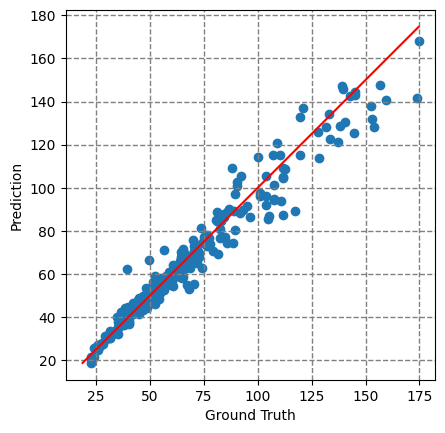

In [16]:
for var_index in np.arange(5):
  X_Train, X_Test, Y_Train, Y_Test = train_test_split(df.iloc[0:-1,5:40],df.iloc[0:-1,var_index], test_size=0.2, random_state=55)

  train_statsY = Y_Train.describe().transpose()
  train_statsX = X_Train.describe().transpose()
  XX = normx(X_Train, train_statsX)
  YY = norm(Y_Train, train_statsY)
  xx = normx(X_Test, train_statsX)
  yy = norm(Y_Test, train_statsY)
  #
  visible = Input(shape=(len(X_Train.keys()),))
  hidden1 = Dense(nnno, activation=ac)(visible)
  hidden1 = Dropout(dr_rate)(hidden1)
  hidden2 = Dense(nnno, activation=ac)(hidden1)
  hidden2 = Dropout(dr_rate)(hidden2)
  mergeA = concatenate([hidden2, visible])
  hiddenB = Dense(nnno, activation=ac)(mergeA)
  hiddenB = Dropout(dr_rate)(hiddenB)
  hidden3 = Dense(nnno, activation=ac)(hiddenB)
  hidden3 = Dropout(dr_rate)(hidden3)
  merge = concatenate([hidden3, visible])
  hidden4 = Dense(nnno, activation=ac)(merge)
  hidden4 = Dropout(dr_rate)(hidden4)
  predicted_value = Dense(1)(hidden4)
  modelANN = Model(inputs=visible, outputs=predicted_value)
  #
  opt = optimizers.Adamax(learning_rate=LR)
  modelANN.compile(optimizer=opt, loss=['mse'])
  history = modelANN.fit(XX, YY,epochs=EPOCHS, validation_data = (xx,yy), verbose=0)
  # plot losses
  plt.figure(var_index+10)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper right')
  plt.show()
  #
  test_predictions = modelANN.predict(xx)
  u1 = denorm(yy, train_statsY).to_numpy()
  u2 = denorm(pd.Series(np.squeeze(test_predictions)), train_statsY)
  # plot truth vs. prediction
  x1 = min(min(u1),min(u2))
  x2 = max(max(u1),max(u2))
  plt.figure(var_index)
  plt.plot([x1,x2],[x1,x2],color='red')
  plt.scatter(u1, u2)
  plt.xlabel('Ground Truth')
  plt.ylabel('Prediction')
  plt.gca().set_aspect('equal', adjustable='box')
  plt.grid(color='grey', linestyle='--', linewidth=1)
  # Errors
  error_ANN, error_ANN_max = mean_aep(u1,u2), max_aep(u1,u2)  
  # Save ANN Results
  if var_index == 0:
    np.savetxt("MUTC_training_loss.csv", history.history['loss'], delimiter=",")
    np.savetxt("MUTC_testing_loss.csv", history.history['val_loss'], delimiter=",")
    np.savetxt("MUTC_phasenoise_truth.csv", u1, delimiter=",")
    np.savetxt("MUTC_phasenoise_predictions.csv", u2, delimiter=",")
  ## LINEAR REGRESSION
  modelLR = LinearRegression()
  modelLR.fit(XX, YY)
  yhat = modelLR.predict(xx)
  u2 = denorm(pd.Series(np.squeeze(yhat)), train_statsY)
  # calculate errors
  error_LR, error_LR_max = mean_aep(u1,u2), max_aep(u1,u2)
  ## k-Nearest Neighbors
  modelkNN = KNeighborsRegressor()
  modelkNN.fit(XX, YY)
  yhat = modelkNN.predict(xx)
  u2 = denorm(pd.Series(np.squeeze(yhat)), train_statsY)
  # calculate errors
  error_kNN, error_kNN_max = mean_aep(u1,u2), max_aep(u1,u2)
  ## RANDOM FOREST  
  modelRF = RandomForestRegressor()
  modelRF.fit(XX, YY)
  yhat = modelRF.predict(xx)
  u2 = denorm(pd.Series(np.squeeze(yhat)), train_statsY)
  # calculate errors
  error_RF, error_RF_max = mean_aep(u1,u2), max_aep(u1,u2)
  # PRINT ERRORS
  print('************',var_index,'************')
  print('Mean Absolute Percentage Errors: LR, kNN, RF, ANN')
  print(error_LR, error_kNN, error_RF, error_ANN)
  print('Max Absolute Percentage Errors: LR, kNN, RF, ANN')
  print(error_LR_max, error_kNN_max, error_RF_max, error_ANN_max)
  backend.clear_session()